In [104]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [105]:
# Load data
df = pd.read_csv("Datasets/Viral_Social_Media_Trends.csv")

In [106]:
df.describe()

,Views,Likes,Shares,Comments
count,5.000000e+03,5000.000000,5000.000000,5000.000000
mean,2.494066e+06,251475.029800,50519.562000,24888.393800
std,1.459490e+06,144349.583384,29066.362671,14284.504319
min,1.266000e+03,490.000000,52.000000,18.000000
25%,1.186207e+06,126892.250000,25029.000000,12305.250000
50%,2.497373e+06,249443.000000,50839.500000,25004.000000
75%,3.759781e+06,373970.750000,75774.250000,37072.750000
max,4.999430e+06,499922.000000,99978.000000,49993.000000


In [107]:

# Drop duplicates
df.drop_duplicates(inplace=True)

# Check for missing values
missing_counts = df.isnull().sum()
print("Missing values per column:\n", missing_counts)

# Impute missing values if any (mode for categorical, median for numeric)
for col in df.select_dtypes(include='object'):
    df[col] = df[col].fillna(df[col].mode()[0])

for col in ['Views', 'Likes', 'Shares', 'Comments']:
    df[col] = df[col].fillna(df[col].median())

# Cap outliers (top 1% of Views)
cap = df['Views'].quantile(0.99)
df['Views'] = np.where(df['Views'] > cap, cap, df['Views'])

Missing values per column:
 Post_ID             0
Platform            0
Hashtag             0
Content_Type        0
Region              0
Views               0
Likes               0
Shares              0
Comments            0
Engagement_Level    0
dtype: int64


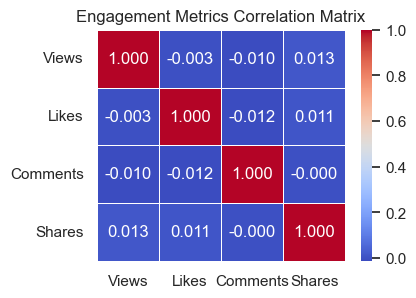

In [108]:
# Select relevant columns
engagement_data = df[['Views', 'Likes', 'Comments', 'Shares']]

# Compute correlation matrix
corr_matrix = engagement_data.corr()

# Plot heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title("Engagement Metrics Correlation Matrix")
plt.show()

This figures show that correlation between numeric figures are low, which indicates problems. We will further examine the dataset.

In [109]:
# Remove rows where Views is zero to avoid division errors
df = df[df["Views"] > 0]

# Define thresholds
LIKE_RATIO_THRESHOLD = 0.3
COMMENT_RATIO_THRESHOLD = 0.1
SHARE_RATIO_THRESHOLD = 0.05

# Apply filters
df_filtered = df[
    (df["Likes"] <= df["Views"]) &
    (df["Comments"] <= df["Views"]) &
    (df["Shares"] <= df["Views"]) &
    ((df["Likes"] / df["Views"]) <= LIKE_RATIO_THRESHOLD) &
    ((df["Comments"] / df["Views"]) <= COMMENT_RATIO_THRESHOLD) &
    ((df["Shares"] / df["Views"]) <= SHARE_RATIO_THRESHOLD)
]

In [110]:
def assign_engagement_level(row):
    # Safeguard in case Views is 0 (though filtered earlier)
    if row['Views'] == 0:
        return "Unknown"
    
    engagement_rate = (row['Likes'] + row['Comments'] + row['Shares']) / row['Views']
    
    if engagement_rate >= 0.6:       # 6% or higher → High
        return "High"
    elif engagement_rate >= 0.03:     # 3% to <6% → Medium
        return "Medium"
    else:                             # <3% → Low
        return "Low"

# Apply the function
df_filtered['Engagement_Level_Calculated'] = df_filtered.apply(assign_engagement_level, axis=1)
df_filtered = df_filtered.drop('Engagement_Level', axis=1)

# Preview the result
df_filtered.head()


/var/folders/ck/gfqchr397y114j5q99r_dw7r0000gn/T/ipykernel_85091/3040004163.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered['Engagement_Level_Calculated'] = df_filtered.apply(assign_engagement_level, axis=1)


,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level_Calculated
0,Post_1,TikTok,#Challenge,Video,UK,4163464.0,339431,53135,19346,Medium
1,Post_2,Instagram,#Education,Shorts,India,4155940.0,215240,65860,27239,Medium
2,Post_3,Twitter,#Challenge,Video,Brazil,3666211.0,327143,39423,36223,Medium
3,Post_4,YouTube,#Education,Shorts,Australia,917951.0,127125,11687,36806,Medium
7,Post_8,YouTube,#Gaming,Shorts,UK,2066886.0,317502,45222,33638,Medium


In [111]:
df_filtered["Engagement_Level_Calculated"] = df_filtered["Engagement_Level_Calculated"].map({
    "Low": 0,
    "Medium": 1,
    "High": 2
})
df_filtered.head()

,Post_ID,Platform,Hashtag,Content_Type,Region,Views,Likes,Shares,Comments,Engagement_Level_Calculated
0,Post_1,TikTok,#Challenge,Video,UK,4163464.0,339431,53135,19346,1
1,Post_2,Instagram,#Education,Shorts,India,4155940.0,215240,65860,27239,1
2,Post_3,Twitter,#Challenge,Video,Brazil,3666211.0,327143,39423,36223,1
3,Post_4,YouTube,#Education,Shorts,Australia,917951.0,127125,11687,36806,1
7,Post_8,YouTube,#Gaming,Shorts,UK,2066886.0,317502,45222,33638,1


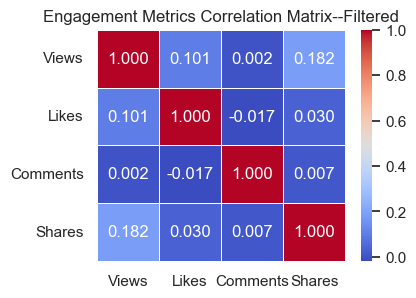

In [112]:
# Select relevant columns
engagement_data_filtered = df_filtered[['Views', 'Likes', 'Comments', 'Shares']]

# Compute correlation matrix
corr_matrix_filtered = engagement_data_filtered.corr()

# Plot heatmap
plt.figure(figsize=(4, 3))
sns.heatmap(corr_matrix_filtered, annot=True, cmap='coolwarm', fmt='.3f', linewidths=0.5)
plt.title("Engagement Metrics Correlation Matrix--Filtered")
plt.show()

In [113]:
print(corr_matrix_filtered)
print(corr_matrix)

             Views     Likes  Comments    Shares
Views     1.000000  0.100691  0.001843  0.181859
Likes     0.100691  1.000000 -0.017438  0.030383
Comments  0.001843 -0.017438  1.000000  0.006947
Shares    0.181859  0.030383  0.006947  1.000000
             Views     Likes  Comments    Shares
Views     1.000000 -0.003211 -0.009954  0.013144
Likes    -0.003211  1.000000 -0.011772  0.011154
Comments -0.009954 -0.011772  1.000000 -0.000132
Shares    0.013144  0.011154 -0.000132  1.000000


In [114]:

# One-hot encode categorical features
df_encoded = pd.get_dummies(df_filtered, columns=['Platform', 'Content_Type', 'Region'])

# Drop non-feature columns
df_encoded = df_encoded.drop(columns=['Post_ID', 'Hashtag'])  # assuming Hashtag won't be modeled directly

# Create 'Conversion Rate' feature
df_encoded['Conversion_Rate'] = df['Shares'] / (df['Likes'] + 1e-5)

In [115]:
df_encoded.head()

,Views,Likes,Shares,Comments,Engagement_Level_Calculated,Platform_Instagram,Platform_TikTok,Platform_Twitter,Platform_YouTube,Content_Type_Live Stream,...,Content_Type_Video,Region_Australia,Region_Brazil,Region_Canada,Region_Germany,Region_India,Region_Japan,Region_UK,Region_USA,Conversion_Rate
0,4163464.0,339431,53135,19346,1,0,1,0,0,0,...,1,0,0,0,0,0,0,1,0,0.156541
1,4155940.0,215240,65860,27239,1,1,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0.305984
2,3666211.0,327143,39423,36223,1,0,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0.120507
3,917951.0,127125,11687,36806,1,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.091933
7,2066886.0,317502,45222,33638,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,0,0.142431


In [116]:
df_encoded.to_csv("Datasets/preprocessed_data.csv", index=False)